In [1]:
!pip install kornia
!pip install torchvision


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import kornia
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


In [3]:
# Define the Generator and Discriminator networks (DCGAN architecture)
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.rotation_head = nn.Linear(768, 4)



    def forward(self, z):
        img = self.model(z)
        rotation_pred = self.rotation_head(img.view(img.size(0), 768))


        return img, rotation_pred

num_classes = 2

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, img):
        return self.model(img)





In [4]:

# Hyperparameters
latent_dim = 100
img_channels = 3  # CIFAR-10 images are in RGB, so 3 channels
batch_size = 64
lr = 0.0002
epochs = 20
sample_interval = 100  # Interval to save generated samples

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks and optimizers
generator = Generator(latent_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(64),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10, interpolation=3, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust these values based on your dataset's specific RGB mean and std
])


test_transform = transforms.Compose([
    transforms.Resize(32),           # Resize to match training images (if you resized them)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])






In [5]:

import torch
from torchvision import datasets
from torch.utils.data import Subset
dataset_path = 'C:/Users/sadia_tisha1/Downloads/aqua_data'

# Function to check if the file is a PNG
def is_png_file(filename):
    return filename.endswith('.png')

# Create the full dataset with the transform
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform, is_valid_file=is_png_file)

# Split the dataset indices
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_indices, test_indices = torch.utils.data.random_split(range(len(full_dataset)), [train_size, test_size])

# Create subsets for training and testing
train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

# Note: Since transforms are already applied to the dataset, you don't need to apply them again.

# Create the DataLoaders
dataloader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=2)



In [6]:
import torchvision.utils as vutils

# Create lists to store losses
d_losses = []
g_losses = []
rotation_losses = []
ssim_values = []


# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Random rotations for self-supervised task
        angle_classes = torch.randint(0, 4, (batch_size,)).to(device)
        angles = angle_classes.float() * 90.0 * (np.pi/180.0)  # Convert to radians
        # Ensure imgs is on the same device as angles
        imgs = imgs.to(device)

        # Now perform the rotation
        rotated_imgs = kornia.geometry.rotate(imgs, angles)

        #rotated_imgs = kornia.geometry.rotate(imgs, angles)

        # Train Discriminator on rotated real images
        optimizer_D.zero_grad()
        real_outputs = discriminator(rotated_imgs)
        real_labels = torch.ones_like(real_outputs)
        real_loss = criterion(real_outputs, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images, _ = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_outputs)
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator on fake images and rotation prediction
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs))

        _, rotation_preds = generator(noise)
        rot_loss = nn.CrossEntropyLoss()(rotation_preds, angle_classes)

        total_g_loss = g_loss + rot_loss
        total_g_loss.backward()
        optimizer_G.step()

        # Print progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [Rotation loss: {rot_loss.item()}]")

        # Append losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        rotation_losses.append(rot_loss.item())

    # Save generated images at specified intervals
    if epoch % sample_interval == 0:
        with torch.no_grad():
            noise = torch.randn(25, latent_dim, 1, 1).to(device)
            generated_images, _ = generator(noise)
            generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]




            # # Plot the generated images
            # fig, ax = plt.subplots()
            # ax.imshow(np.transpose(vutils.make_grid(generated_images.device(), padding=2, normalize=True), (1,2,0)))
            # plt.show()




[Epoch 0/20] [Batch 0/141] [D loss: 1.4366655349731445] [G loss: 1.290751576423645] [Rotation loss: 1.392653465270996]
[Epoch 0/20] [Batch 100/141] [D loss: 0.005832558497786522] [G loss: 7.847085475921631] [Rotation loss: 1.418060302734375]
[Epoch 1/20] [Batch 0/141] [D loss: 0.004586120136082172] [G loss: 7.945211410522461] [Rotation loss: 1.4128549098968506]
[Epoch 1/20] [Batch 100/141] [D loss: 0.004017990082502365] [G loss: 8.664215087890625] [Rotation loss: 1.387491226196289]
[Epoch 2/20] [Batch 0/141] [D loss: 0.0026012721937149763] [G loss: 7.310260772705078] [Rotation loss: 1.3915303945541382]
[Epoch 2/20] [Batch 100/141] [D loss: 0.0012550547253340483] [G loss: 8.940777778625488] [Rotation loss: 1.4055734872817993]
[Epoch 3/20] [Batch 0/141] [D loss: 0.0008254771819338202] [G loss: 8.275877952575684] [Rotation loss: 1.38643217086792]
[Epoch 3/20] [Batch 100/141] [D loss: 0.0007797866128385067] [G loss: 8.296459197998047] [Rotation loss: 1.3817191123962402]
[Epoch 4/20] [Batch

In [7]:

# # Save the generator and discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


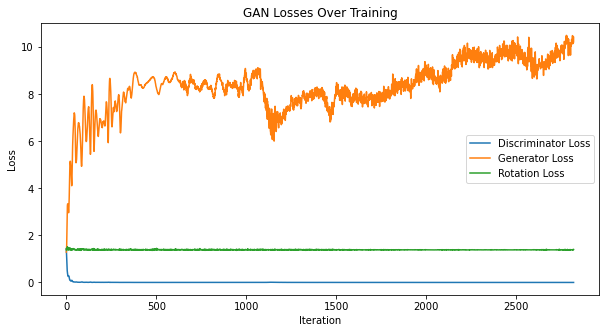

In [8]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.plot(rotation_losses, label="Rotation Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN Losses Over Training")
plt.show()



In [9]:
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils

# # Load the saved generator model
# generator.load_state_dict(torch.load('generator.pth'))
# generator.eval()

# # Generate a batch of fake images
# with torch.no_grad():
#     noise = torch.randn(25, latent_dim, 1, 1)
#     generated_images, _ = generator(noise)

#     generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]


# # Display the generated images in a grid
# fig = plt.figure(figsize=(5, 5))
# plt.axis("off")
# plt.title("Generated Images")
# plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
# plt.show()


In [10]:
class DiscriminatorForClassification(nn.Module):
    def __init__(self, img_channels, num_classes=10):
        super(DiscriminatorForClassification, self).__init__()
        # Define your convolutional layers here
        self.features = nn.Sequential(
            # Assuming these are your convolutional layers
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # Add more layers as needed
        )

        self.flatten_size = self._get_flatten_size((img_channels, 32, 32))
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, num_classes)
        )

    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            input = torch.zeros(1, *input_shape)
            output = self.features(input)
            return int(np.prod(output.size()[1:]))

    def forward(self, img):
        out = self.features(img)
        out = out.view(out.size(0), -1)
        class_output = self.classifier(out)
        return class_output



In [11]:
# Load the discriminator with the pre-trained weights
pretrained_discriminator = Discriminator(img_channels).to(device)
pretrained_discriminator.load_state_dict(torch.load('discriminator.pth'))

# Create the new discriminator for classification
discriminator_classifier = DiscriminatorForClassification(img_channels).to(device)

# Transfer weights from pretrained discriminator, except for the classifier layer
discriminator_classifier.features.load_state_dict(pretrained_discriminator.model.state_dict(), strict=False)

# Define a new optimizer and loss function for fine-tuning
optimizer = optim.Adam(discriminator_classifier.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
for epoch in range(30):
    for i, (imgs, labels) in enumerate(dataloader):
        #imgs, labels = imgs, labels
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = discriminator_classifier(imgs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{30}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')



Epoch [1/30], Step [100/141], Loss: 0.3307065963745117
Epoch [2/30], Step [100/141], Loss: 0.24058350920677185
Epoch [3/30], Step [100/141], Loss: 0.3116762042045593
Epoch [4/30], Step [100/141], Loss: 0.3828204274177551
Epoch [5/30], Step [100/141], Loss: 0.2813694179058075
Epoch [6/30], Step [100/141], Loss: 0.3732755184173584
Epoch [7/30], Step [100/141], Loss: 0.341511994600296
Epoch [8/30], Step [100/141], Loss: 0.320637047290802
Epoch [9/30], Step [100/141], Loss: 0.2439800351858139
Epoch [10/30], Step [100/141], Loss: 0.34256407618522644
Epoch [11/30], Step [100/141], Loss: 0.3474022150039673
Epoch [12/30], Step [100/141], Loss: 0.23454244434833527
Epoch [13/30], Step [100/141], Loss: 0.28731104731559753
Epoch [14/30], Step [100/141], Loss: 0.2475084811449051
Epoch [15/30], Step [100/141], Loss: 0.3330567181110382
Epoch [16/30], Step [100/141], Loss: 0.22888042032718658
Epoch [17/30], Step [100/141], Loss: 0.3277978003025055
Epoch [18/30], Step [100/141], Loss: 0.203540116548538

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is your DataLoader for test data
        images, labels = images.to(device), labels.to(device)
        outputs = discriminator_classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 89.7424511545293%


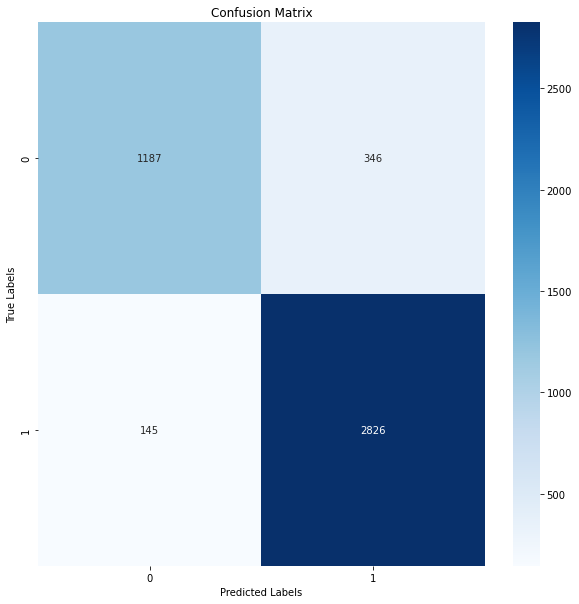

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = discriminator_classifier(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [1]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = discriminator_classifier(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'torch' is not defined